# Monte Carlo Tree Search for Reasoning

Best-of-N generates solutions independently. Tree of Thoughts explores a tree but uses simple heuristics. MCTS combines the best of both: systematic tree exploration guided by learned value estimates.

This is how AlphaGo beat the world champion at Go. And it's how some of the best reasoning systems work today.

## The Core Idea

MCTS builds a search tree through repeated simulations. Each simulation has four phases:

```
┌─────────────────────────────────────────────────────────────────┐
│  1. SELECT                                                       │
│     Start at root, use UCB formula to pick child nodes          │
│     until reaching an unexplored node                            │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│  2. EXPAND                                                       │
│     Add child nodes for possible next steps                      │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│  3. SIMULATE (Rollout)                                           │
│     Play out to the end (or use value estimate)                  │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│  4. BACKPROPAGATE                                                │
│     Update value estimates along the path                        │
└─────────────────────────────────────────────────────────────────┘
```

Repeat many times, then pick the most-visited (or highest-value) action.

## The UCB Formula

The core of MCTS is the **Upper Confidence Bound** (UCB) formula for selecting which branch to explore:

$$\text{UCB}(s, a) = Q(s, a) + c \cdot \sqrt{\frac{\ln N(s)}{N(s, a)}}$$

Where:
- $Q(s, a)$ = Average value of taking action $a$ in state $s$
- $N(s)$ = Number of times we've visited state $s$
- $N(s, a)$ = Number of times we've taken action $a$ from state $s$
- $c$ = Exploration constant (balances exploration vs. exploitation)

The first term favors **exploitation** (actions that worked well before).
The second term favors **exploration** (actions we haven't tried much).

As $N(s, a)$ increases, the exploration bonus shrinks. Eventually, focus shifts to the best actions.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Callable
import numpy as np
import math
import matplotlib.pyplot as plt

# Load model
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype="auto")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
model = model.to(device)
model.eval()

print(f"Loaded on {device}")

Loading Qwen/Qwen2.5-0.5B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Loaded on cuda


In [2]:
@dataclass
class MCTSNode:
    """
    A node in the MCTS tree.
    """
    state: str                     # The reasoning state so far
    thought: str = ""              # The thought that led here
    parent: Optional['MCTSNode'] = None
    children: Dict[str, 'MCTSNode'] = field(default_factory=dict)
    
    # MCTS statistics
    visits: int = 0
    value_sum: float = 0.0
    
    @property
    def value(self) -> float:
        """Average value (Q-value)."""
        if self.visits == 0:
            return 0.0
        return self.value_sum / self.visits
    
    def ucb_score(self, c: float = 1.41) -> float:
        """
        Compute UCB score for this node.
        
        c=1.41 ≈ sqrt(2) is a common default.
        """
        if self.visits == 0:
            return float('inf')  # Unexplored = infinite priority
        
        if self.parent is None:
            return self.value
        
        exploitation = self.value
        exploration = c * math.sqrt(math.log(self.parent.visits) / self.visits)
        
        return exploitation + exploration
    
    def is_leaf(self) -> bool:
        return len(self.children) == 0
    
    def best_child(self, c: float = 1.41) -> 'MCTSNode':
        """Select child with highest UCB score."""
        return max(self.children.values(), key=lambda n: n.ucb_score(c))
    
    def most_visited_child(self) -> 'MCTSNode':
        """Select most-visited child (for final action selection)."""
        return max(self.children.values(), key=lambda n: n.visits)


print("MCTSNode defined.")

MCTSNode defined.


In [3]:
def generate_thoughts(state: str, n: int = 3, temperature: float = 0.8) -> List[str]:
    """
    Generate n possible next thoughts from a state.
    """
    prompt = f"{state}\n\nWhat is a good next step? Respond with just the next step:"
    
    thoughts = []
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    for _ in range(n):
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                temperature=temperature,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
            )
        
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        thought = text[len(prompt):].strip().split('\n')[0]
        if thought and thought not in thoughts:
            thoughts.append(thought)
    
    return thoughts


def evaluate_state(state: str) -> float:
    """
    Evaluate a reasoning state (simple heuristic).
    
    In practice, you'd use a trained value network or PRM.
    """
    score = 0.5
    
    # Reward step-by-step reasoning
    if 'step' in state.lower():
        score += 0.1
    
    # Reward calculations
    import re
    if re.search(r'\d+\s*[+\-*/]\s*\d+\s*=', state):
        score += 0.2
    
    # Reward final answer
    if 'answer' in state.lower():
        score += 0.1
    
    return min(1.0, score)


# Test
test_state = "Problem: What is 5 + 3?\nLet me think step by step."
thoughts = generate_thoughts(test_state, n=3)
print("Generated thoughts:")
for i, t in enumerate(thoughts, 1):
    print(f"  {i}. {t}")

Generated thoughts:
  1. After solving 5 + 3, we find that it equals 8. Therefore, our answer is 8.
  2. To find the sum of 5 and 3, I need to perform the addition.
  3. To solve this addition problem, I need to add the numbers together. 


In [4]:
class MCTS:
    """
    Monte Carlo Tree Search for language model reasoning.
    """
    
    def __init__(self, expand_fn: Callable, evaluate_fn: Callable,
                 c: float = 1.41, max_depth: int = 5):
        self.expand_fn = expand_fn      # Generate possible next thoughts
        self.evaluate_fn = evaluate_fn  # Evaluate a state
        self.c = c                      # Exploration constant
        self.max_depth = max_depth
    
    def select(self, node: MCTSNode) -> MCTSNode:
        """
        Phase 1: Select a leaf node using UCB.
        """
        current = node
        depth = 0
        
        while not current.is_leaf() and depth < self.max_depth:
            current = current.best_child(self.c)
            depth += 1
        
        return current
    
    def expand(self, node: MCTSNode, n_children: int = 3) -> MCTSNode:
        """
        Phase 2: Expand by adding child nodes.
        """
        if node.visits == 0:
            # First visit — just return the node to evaluate
            return node
        
        # Generate possible next thoughts
        thoughts = self.expand_fn(node.state, n=n_children)
        
        for thought in thoughts:
            if thought not in node.children:
                new_state = f"{node.state}\n{thought}"
                child = MCTSNode(
                    state=new_state,
                    thought=thought,
                    parent=node
                )
                node.children[thought] = child
        
        # Return a random new child to evaluate
        if node.children:
            unvisited = [c for c in node.children.values() if c.visits == 0]
            if unvisited:
                return np.random.choice(unvisited)
            return node.best_child(self.c)
        
        return node
    
    def simulate(self, node: MCTSNode) -> float:
        """
        Phase 3: Evaluate the node (or rollout).
        
        In classic MCTS, this plays random moves to terminal state.
        With LLMs, we typically just use a value estimate.
        """
        return self.evaluate_fn(node.state)
    
    def backpropagate(self, node: MCTSNode, value: float):
        """
        Phase 4: Update values along the path to root.
        """
        current = node
        while current is not None:
            current.visits += 1
            current.value_sum += value
            current = current.parent
    
    def search(self, root: MCTSNode, n_simulations: int = 50) -> MCTSNode:
        """
        Run MCTS for n_simulations and return best node.
        """
        for i in range(n_simulations):
            # 1. Select
            leaf = self.select(root)
            
            # 2. Expand
            node = self.expand(leaf)
            
            # 3. Simulate
            value = self.simulate(node)
            
            # 4. Backpropagate
            self.backpropagate(node, value)
        
        return root.most_visited_child() if root.children else root
    
    def solve(self, problem: str, n_simulations: int = 50, 
              n_steps: int = 3) -> dict:
        """
        Solve a problem using MCTS.
        """
        # Initialize root
        root = MCTSNode(
            state=f"Problem: {problem}\nLet me solve this step by step."
        )
        
        # Build solution step by step
        current = root
        path = []
        
        for step in range(n_steps):
            # Run MCTS from current node
            best = self.search(current, n_simulations=n_simulations)
            
            if best.thought:
                path.append(best.thought)
            current = best
            
            # Check if we've reached an answer
            if 'answer' in current.state.lower():
                break
        
        return {
            "solution": current.state,
            "path": path,
            "value": current.value,
            "visits": current.visits,
            "root": root
        }


# Create MCTS solver
mcts = MCTS(
    expand_fn=generate_thoughts,
    evaluate_fn=evaluate_state,
    c=1.41,
    max_depth=5
)

print("MCTS solver ready.")

MCTS solver ready.


In [5]:
# Test MCTS
problem = "What is 12 + 8?"

print(f"Problem: {problem}")
print(f"Correct: 20")
print("\n" + "="*60)
print("Running MCTS...")

result = mcts.solve(problem, n_simulations=20, n_steps=3)

print("\n" + "="*60)
print("SOLUTION PATH:")
print("="*60)
for i, step in enumerate(result['path'], 1):
    print(f"Step {i}: {step}")

print(f"\nFinal value: {result['value']:.3f}")
print(f"Total visits: {result['visits']}")

Problem: What is 12 + 8?
Correct: 20

Running MCTS...



SOLUTION PATH:
Step 1: Solution:
Step 2: Solution: First, let's add the two numbers together. We can start at 12 and move to 8. The sum of 12 and 8 is 20.
Step 3: Next, we should round our answer up to the nearest ten.

Final value: 0.737
Total visits: 16


## Visualizing the Search Tree

One of the nice things about MCTS is that we can visualize what it explored.

In [6]:
def print_tree(node: MCTSNode, indent: int = 0, max_depth: int = 3):
    """
    Print the MCTS tree structure.
    """
    if indent > max_depth * 2:
        return
    
    prefix = "  " * indent
    thought_preview = node.thought[:40] + "..." if len(node.thought) > 40 else node.thought
    
    if node.thought:
        print(f"{prefix}├─ {thought_preview}")
        print(f"{prefix}│  visits={node.visits}, value={node.value:.2f}, ucb={node.ucb_score():.2f}")
    else:
        print(f"{prefix}[ROOT] visits={node.visits}")
    
    for child in sorted(node.children.values(), key=lambda n: -n.visits):
        print_tree(child, indent + 1, max_depth)


print("MCTS Search Tree:")
print("="*60)
print_tree(result['root'], max_depth=2)

MCTS Search Tree:
[ROOT] visits=60
  ├─ Solution:
  │  visits=47, value=0.69, ucb=1.11
    ├─ Solution: First, let's add the two numbe...
    │  visits=29, value=0.69, ucb=1.21
      ├─ Next, we should round our answer up to t...
      │  visits=16, value=0.74, ucb=1.38
        ├─ Solution: Next, we need to round our ans...
        │  visits=5, value=0.70, ucb=1.75
        ├─ The sum is 20. Now what?
        │  visits=5, value=0.70, ucb=1.75
        ├─ Round 20 to the nearest ten.
        │  visits=5, value=0.82, ucb=1.87
      ├─ Solution:
      │  visits=12, value=0.64, ucb=1.39
        ├─ Solution:
        │  visits=4, value=0.62, ucb=1.74
        ├─ Solution: Let's verify our answer.
        │  visits=4, value=0.70, ucb=1.81
        ├─ Solution: Let's calculate it.
        │  visits=3, value=0.60, ucb=1.88
    ├─ Add up the two numbers.
    │  visits=9, value=0.71, ucb=1.63
      ├─ Add them together.
      │  visits=3, value=0.63, ucb=1.84
        ├─ The next step would be to add 

## MCTS with Learned Value Function

In AlphaGo (and AlphaZero), MCTS uses a neural network to:
1. **Prior policy**: Bias initial exploration toward promising moves
2. **Value function**: Replace rollouts with learned value estimates

For LLM reasoning, this means:
1. Use the LLM's own probabilities as priors
2. Use a PRM or value head for evaluation

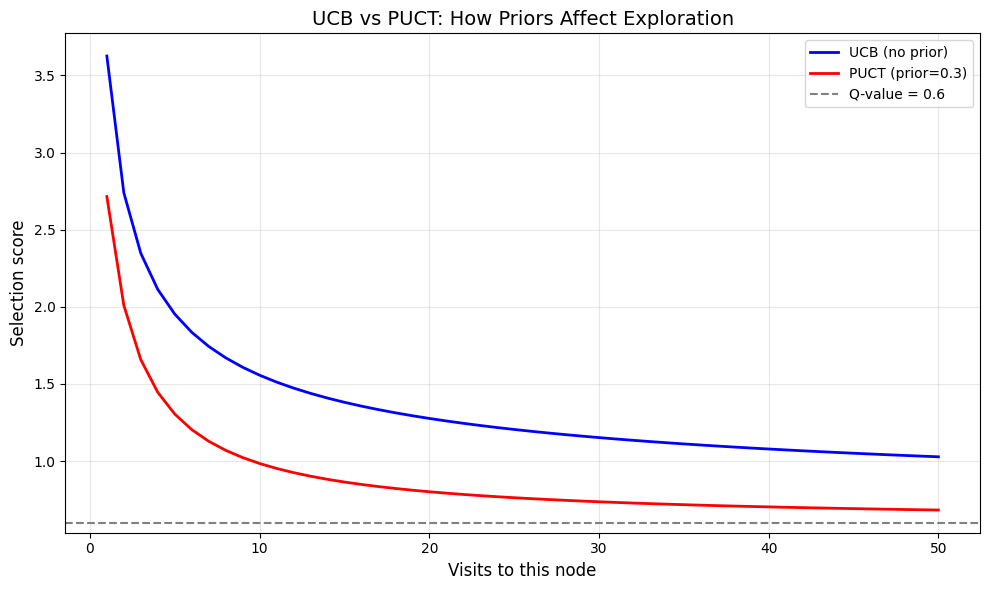

PUCT with high prior → more initial exploration of that action.
PUCT with low prior → less exploration, need strong evidence to try.


In [7]:
def puct_score(node: MCTSNode, prior: float, c_puct: float = 1.0) -> float:
    """
    PUCT formula (Predictor + UCT) used in AlphaGo.
    
    Incorporates a prior probability from the policy network.
    
    PUCT(s, a) = Q(s, a) + c * P(a|s) * sqrt(N(s)) / (1 + N(s, a))
    """
    if node.parent is None:
        return node.value
    
    exploitation = node.value
    exploration = c_puct * prior * math.sqrt(node.parent.visits) / (1 + node.visits)
    
    return exploitation + exploration


# Visualize UCB vs PUCT
visits = np.arange(1, 51)
parent_visits = 100
q_value = 0.6
c = 1.41
prior = 0.3  # Model thinks this action has 30% probability

ucb_scores = [q_value + c * math.sqrt(math.log(parent_visits) / v) for v in visits]
puct_scores = [q_value + c * prior * math.sqrt(parent_visits) / (1 + v) for v in visits]

plt.figure(figsize=(10, 6))
plt.plot(visits, ucb_scores, 'b-', label='UCB (no prior)', linewidth=2)
plt.plot(visits, puct_scores, 'r-', label=f'PUCT (prior={prior})', linewidth=2)
plt.axhline(y=q_value, color='gray', linestyle='--', label=f'Q-value = {q_value}')
plt.xlabel('Visits to this node', fontsize=12)
plt.ylabel('Selection score', fontsize=12)
plt.title('UCB vs PUCT: How Priors Affect Exploration', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("PUCT with high prior → more initial exploration of that action.")
print("PUCT with low prior → less exploration, need strong evidence to try.")

## Benchmark: AlphaMath Results

From the AlphaMath paper (using MCTS for math reasoning):

| Method | GSM8K | MATH |
|--------|-------|------|
| Base model | 51.1% | 7.2% |
| + CoT | 58.3% | 12.5% |
| + MCTS (1 round) | 63.2% | 18.4% |
| + MCTS (3 rounds) | **78.8%** | **41.2%** |

MCTS + iterative refinement gets massive improvements!

## What We've Learned

MCTS applies game-tree search to reasoning:

1. **Select**: Use UCB to balance exploration/exploitation
2. **Expand**: Generate possible next thoughts
3. **Simulate**: Evaluate with value function (or rollout)
4. **Backpropagate**: Update statistics up the tree

The UCB formula:
$$\text{UCB}(s, a) = Q(s, a) + c \cdot \sqrt{\frac{\ln N(s)}{N(s, a)}}$$

With priors (PUCT):
$$\text{PUCT}(s, a) = Q(s, a) + c \cdot P(a|s) \cdot \frac{\sqrt{N(s)}}{1 + N(s, a)}$$

Key advantages over Best-of-N:
- Explores promising paths more deeply
- Abandons bad branches early
- Uses compute more efficiently

**Next up:** Budget Forcing — controlling reasoning length with "Wait" tokens